In [1]:
import os
import utils
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import *
import statsmodels.formula.api as smf
from glob import glob
from datetime import datetime
import tensorflow as tf
import keras
from keras import Input, layers
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D, LeakyReLU, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.utils import np_utils
import random
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from scipy import stats
from sklearn.linear_model import LinearRegression
from fireTS.models import NARX
seed_value = 2022
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
from sklearn.preprocessing import QuantileTransformer 
normalizer = QuantileTransformer(output_distribution='normal')

In [2]:
def baSpread(x):
    a=x['AP1'].values.tolist()
    b=x['BP1'].values.tolist()
    bas=np.empty(len(x))
    for i in range(len(a)):
       bas[i]=(a[i]/10**4-b[i]/10**4)#/(a[i]+b[i])*10**4
    return bas

In [3]:
lob_data=utils.caricaLOB('msft',0.1)
ld=lob_data.values.tolist()
of=utils.OF_1(ld)
bCols=np.ravel([['aOF_%d'%level, 'bOF_%d'%level] for level in [1,2,3]])
of_data=pd.DataFrame(of, columns=bCols)
m=pd.DataFrame(utils.midPrice(lob_data),columns=['m'])
m['r']=m['m'].pct_change().fillna(0).copy()
b=pd.DataFrame(baSpread(lob_data),columns=['spread'])
b['d']=b['spread'].diff().dropna()

In [4]:
spread=b['d'].fillna(0).to_numpy()
np.quantile(spread,0.9), np.quantile(spread,0.1)

(0.010000000000005116, -0.010000000000005116)

In [5]:

hot=np.zeros(len(spread))
for i in range(0,len(hot)):
    if spread[i]>0.01: 
        hot[i]=1 
    elif spread[i]<-0.01:
        hot[i]=2 
    else:
        hot[i]=0


In [6]:
np.quantile(spread,0.9), np.quantile(spread,0.1)

(0.010000000000005116, -0.010000000000005116)

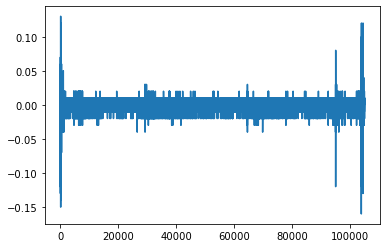

In [7]:
plt.plot(spread)

In [8]:
spread,hot

(array([0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.01]),
 array([0., 0., 0., ..., 0., 0., 0.]))

CNN-LSTM Classifier
===

In [9]:
def prepare_x_y(of, lag=100, dimension=6):
    ex = of[['aOF_1','bOF_1','aOF_2','bOF_2','aOF_3','bOF_3']].to_numpy()#
    uai= of['h'].to_numpy() #.pct_change().fillna(0)['r']
    shape = of.shape
    dimension=6
    lag = 100
    x=np.empty((shape[0]-lag, lag, dimension))
    y=np.empty((shape[0]-lag,1))
    for i in range(shape[0]-lag):
        x[i]=ex[i:i+lag]
        y[i]=uai[i+lag-1]

    X=x.reshape(-1,lag,6,1)

    Y = np_utils.to_categorical(y.astype(int),3)

    return X,Y

In [10]:
V = int(len(of)*0.6)
T = int(len(of)*0.8)

n_train     = of_data.iloc[ :V].copy()
n_vali      = of_data.iloc[V:T].copy()
n_test      = of_data.iloc[T: ].copy()

n_train = n_train.apply(lambda x : utils.taglia_e_cuci(x), axis=1, raw=True)
n_vali  = n_vali .apply(lambda x : utils.taglia_e_cuci(x), axis=1, raw=True)
n_test  = n_test .apply(lambda x : utils.taglia_e_cuci(x), axis=1, raw=True)

x_vars = of_data.columns#[:-1]

# Normalize Features
# Dividing by the standard deviation estimated using the training set
for x_var in x_vars:
    sd = n_train[x_var].std()
    n_train[x_var] = n_train[x_var] / sd
    n_vali [x_var] = n_vali [x_var] / sd
    n_test [x_var] = n_test [x_var] / sd

n_train['h'] = hot[ :V]
n_vali ['h'] = hot[V:T]
n_test ['h'] = hot[T: ]
#of=of_data

trainX,trainY = prepare_x_y  (n_train)    
valiX ,valiY  = prepare_x_y  (n_vali )    
testX ,testY  = prepare_x_y  (n_test )   


print(trainX.shape ,trainY.shape)
print(valiX.shape  ,valiY .shape)
print(testX.shape  ,testY .shape)

(62814, 100, 6, 1) (62814, 3)
(20871, 100, 6, 1) (20871, 3)
(20872, 100, 6, 1) (20872, 3)


In [11]:

def create_nn(T, NF,number_of_lstm):

    input_lmd = tf.keras.Input(shape=(T, NF, 1))

    conv_first1 = Conv2D(32, kernel_size=(1, 2), strides=(1, 2))(input_lmd)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    #
    layer_x = layers.Conv2D(filters=16, kernel_size=(10,1),strides=(1,10), padding='same')(conv_first1)
    layer_x = layers.LeakyReLU(alpha=0.01)(layer_x)
    # inception
    convsecond_1 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(layer_x)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)
    convsecond_1 = Conv2D(64, (3, 1), padding='same', strides=(1,1))(convsecond_1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)

    convsecond_2 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(layer_x)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)
    convsecond_2 = Conv2D(64, (5, 1), padding='same', strides=(1,1))(convsecond_2)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)

    convsecond_3 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(layer_x)
    convsecond_3 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(convsecond_3)
    convsecond_3 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_3)
    
    convsecond_output = keras.layers.concatenate([convsecond_1, convsecond_2, convsecond_3], axis=3)
    conv_reshape = Reshape((int(convsecond_output.shape[1]), int(convsecond_output.shape[3])))(convsecond_output)
    conv_reshape = keras.layers.Dropout(0.7, noise_shape=(None, 1, int(conv_reshape.shape[2])))(conv_reshape, training=True)

    # build the last LSTM layer
    conv_lstm = LSTM(number_of_lstm)(conv_reshape)

    # build the output layer
    out = Dense(3, activation='softmax')(conv_lstm)
    model = Model(inputs=input_lmd, outputs=out)
    adam = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])#

    return model
checkpoint_filepath = './model_tensorflow2/weights_class'
deeplob = create_nn(100, 6, 64)
deeplob.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 6, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 100, 3, 32)   96          ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 100, 3, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 100, 3, 32)   4128        ['leaky_re_lu[0][0]']            
                                                                                              

In [12]:
callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)
saving = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [13]:
#deeplob.load_weights('modelMSFTClassification.h5')
simple=deeplob.fit(trainX, trainY, validation_data=(valiX, valiY),  epochs=50, batch_size=256,callbacks=[callback,saving])

Epoch 1/50
246/246 [==============================] - 56s 223ms/step - loss: 0.8025 - accuracy: 0.7282 - val_loss: 0.7461 - val_accuracy: 0.7355
Epoch 2/50
246/246 [==============================] - 96s 390ms/step - loss: 0.6948 - accuracy: 0.7358 - val_loss: 0.6416 - val_accuracy: 0.7361
Epoch 3/50
246/246 [==============================] - 114s 462ms/step - loss: 0.5902 - accuracy: 0.7460 - val_loss: 0.5347 - val_accuracy: 0.7555
Epoch 4/50
246/246 [==============================] - 117s 476ms/step - loss: 0.5154 - accuracy: 0.7559 - val_loss: 0.4902 - val_accuracy: 0.7593
Epoch 5/50
246/246 [==============================] - 123s 500ms/step - loss: 0.4876 - accuracy: 0.7602 - val_loss: 0.4729 - val_accuracy: 0.7650
Epoch 6/50
246/246 [==============================] - 129s 524ms/step - loss: 0.4746 - accuracy: 0.7609 - val_loss: 0.4685 - val_accuracy: 0.7696
Epoch 7/50
246/246 [==============================] - 125s 507ms/step - loss: 0.4670 - accuracy: 0.7669 - val_loss: 0.4707 - v

In [14]:
deeplob.save('modelMSFTdiffClassification.h5')

In [15]:
P = deeplob.predict(testX)
pj= np.round(P)
P

653/653 [==============================] - 36s 50ms/step


array([[8.1334454e-01, 1.1415280e-01, 7.2502680e-02],
       [9.9700445e-01, 3.1326857e-04, 2.6822649e-03],
       [9.9845874e-01, 6.4479053e-04, 8.9654897e-04],
       ...,
       [5.6730777e-01, 2.8030844e-03, 4.2988917e-01],
       [9.9565756e-01, 2.3417587e-04, 4.1083219e-03],
       [9.9724472e-01, 2.2831643e-03, 4.7218744e-04]], dtype=float32)

In [16]:
from sklearn.metrics import classification_report, accuracy_score
print('accuracy_score:', accuracy_score(np.argmax(testY, axis=1), np.argmax(pj, axis=1)))
print(classification_report(np.argmax(testY, axis=1), np.argmax(pj, axis=1), digits=4))

accuracy_score: 0.7855500191644308
              precision    recall  f1-score   support

           0     0.8636    0.8520    0.8578     15802
           1     0.5625    0.6915    0.6204      2603
           2     0.5437    0.4589    0.4977      2467

    accuracy                         0.7856     20872
   macro avg     0.6566    0.6675    0.6586     20872
weighted avg     0.7883    0.7856    0.7856     20872



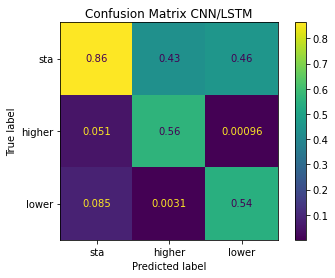

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(testY.argmax(axis=1), pj.argmax(axis=1),normalize='pred')#true', 'pred', 'all'
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['sta','higher','lower'])
disp.plot()
disp.ax_.set_title("Confusion Matrix CNN/LSTM");

LSTM classifier
===

In [18]:
def prepare_x_y_lstm(of, lag=100, dimension=6):
    ex = of[['aOF_1','bOF_1','aOF_2','bOF_2','aOF_3','bOF_3']].to_numpy()#
    uai= of['h'].to_numpy() #.pct_change().fillna(0)['r']
    shape = of.shape
    dimension=6
    lag = 100
    x=np.empty((shape[0]-lag, lag, dimension))
    y=np.empty((shape[0]-lag,1))
    for i in range(shape[0]-lag):
        x[i]=ex[i:i+lag]
        y[i]=uai[i+lag-1]

    X=x.reshape(-1,lag,6)

    Y = np_utils.to_categorical(y.astype(int),3)

    return X,Y

In [19]:
V = int(len(of)*0.6)
T = int(len(of)*0.8)

n_train     = of_data.iloc[ :V].copy()
n_vali      = of_data.iloc[V:T].copy()
n_test      = of_data.iloc[T: ].copy()

n_train = n_train.apply(lambda x : utils.taglia_e_cuci(x), axis=1, raw=True)
n_vali  = n_vali .apply(lambda x : utils.taglia_e_cuci(x), axis=1, raw=True)
n_test  = n_test .apply(lambda x : utils.taglia_e_cuci(x), axis=1, raw=True)

x_vars = of_data.columns#[:-1]

# Normalize Features
# Dividing by the standard deviation estimated using the training set
for x_var in x_vars:
    sd = n_train[x_var].std()
    n_train[x_var] = n_train[x_var] / sd
    n_vali [x_var] = n_vali [x_var] / sd
    n_test [x_var] = n_test [x_var] / sd

n_train['h'] = hot[ :V]
n_vali ['h'] = hot[V:T]
n_test ['h'] = hot[T: ]
#of=of_data

trainX_lstm,trainY_lstm = prepare_x_y_lstm  (n_train)    
valiX_lstm,valiY_lstm = prepare_x_y_lstm  (n_vali )    
testX_lstm,testY_lstm = prepare_x_y_lstm  (n_test )   


print(trainX_lstm.shape ,trainY_lstm .shape)
print(valiX_lstm.shape  ,valiY_lstm .shape)
print(testX_lstm.shape  ,testY_lstm .shape)

(62814, 100, 6) (62814, 3)
(20871, 100, 6) (20871, 3)
(20872, 100, 6) (20872, 3)


In [20]:
#architettura della rete
num_units = 64
activation_function = 'leaky_relu'
adam = keras.optimizers.Adam(learning_rate=0.001)
loss_function = 'categorical_crossentropy'
batch_size = 250
num_epochs = 50
i = Input(shape=(100, 6))
x = LSTM(64, return_sequences=True)(i)
x = keras.layers.LeakyReLU(alpha=0.01)(x)
x = LSTM(64, return_sequences=True)(x)
x = keras.layers.LeakyReLU(alpha=0.01)(x)
x = LSTM(64, return_sequences=True)(x)
x = keras.layers.LeakyReLU(alpha=0.01)(x)
x = keras.layers.Dropout(0.7)(x, training=True)
#x = LSTM(64, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(3, activation='softmax')(x)


model = Model(i, x)


callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

model.compile(optimizer = adam, loss = loss_function, metrics=['accuracy'])
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 6)]          0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 64)           18176     
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 100, 64)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 64)           33024     
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 100, 64)           0         
                                                                 
 lstm_3 (LSTM)               (None, 100, 64)           33024     
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 100, 64)           0   

In [21]:
#model.load_weights('modelMSFTlstmClassification.h5')
lstmMSFT=model.fit(trainX_lstm, trainY_lstm, validation_data=(valiX_lstm, valiY_lstm), epochs=20, batch_size=256)

Epoch 1/20
246/246 [==============================] - 390s 2s/step - loss: 0.7698 - accuracy: 0.7315 - val_loss: 0.7644 - val_accuracy: 0.7356
Epoch 2/20
246/246 [==============================] - 378s 2s/step - loss: 0.7589 - accuracy: 0.7361 - val_loss: 0.7623 - val_accuracy: 0.7356
Epoch 3/20
246/246 [==============================] - 181s 734ms/step - loss: 0.7579 - accuracy: 0.7361 - val_loss: 0.7631 - val_accuracy: 0.7356
Epoch 4/20
246/246 [==============================] - 156s 635ms/step - loss: 0.7571 - accuracy: 0.7361 - val_loss: 0.7655 - val_accuracy: 0.7356
Epoch 5/20
246/246 [==============================] - 158s 645ms/step - loss: 0.7566 - accuracy: 0.7361 - val_loss: 0.7614 - val_accuracy: 0.7356
Epoch 6/20
246/246 [==============================] - 161s 655ms/step - loss: 0.7563 - accuracy: 0.7361 - val_loss: 0.7630 - val_accuracy: 0.7356
Epoch 7/20
246/246 [==============================] - 159s 649ms/step - loss: 0.7556 - accuracy: 0.7361 - val_loss: 0.7676 - val_a

In [22]:
model.save('modelMSFTlstmDiffClassification.h5')

In [23]:
P_lstm = model.predict(testX_lstm)
p_lstmj= np.round(P_lstm)
P_lstm

653/653 [==============================] - 20s 28ms/step


array([[0.8639507 , 0.05783703, 0.07821228],
       [0.84776986, 0.06807799, 0.08415216],
       [0.8369957 , 0.08922221, 0.07378206],
       ...,
       [0.6602964 , 0.16111182, 0.17859182],
       [0.7780135 , 0.10792422, 0.11406227],
       [0.91647375, 0.04377502, 0.03975115]], dtype=float32)

In [30]:
from sklearn.metrics import classification_report, accuracy_score
print('accuracy_score:', accuracy_score(np.argmax(testY_lstm, axis=1), np.argmax(P_lstm, axis=1)))
print(classification_report(np.argmax(testY_lstm, axis=1), np.argmax(P_lstm, axis=1), digits=4))

accuracy_score: 0.7598696818704485
              precision    recall  f1-score   support

           0     0.7653    0.9893    0.8630     15802
           1     0.5220    0.0864    0.1483      2603
           2     0.1538    0.0008    0.0016      2467

    accuracy                         0.7599     20872
   macro avg     0.4804    0.3589    0.3376     20872
weighted avg     0.6627    0.7599    0.6720     20872



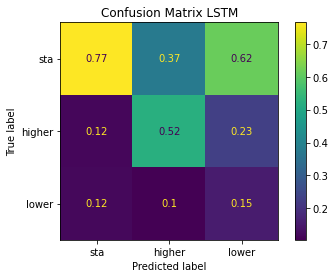

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_lstm = confusion_matrix(testY_lstm.argmax(axis=1), P_lstm.argmax(axis=1),normalize='pred')#true', 'pred', 'all'
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm,display_labels=['sta','higher','lower'])
disp_lstm.plot()
disp_lstm.ax_.set_title("Confusion Matrix LSTM");

Naive Gaussian Classifier
===

In [25]:
rng = np.random.RandomState(1)
X = n_train[['aOF_1'	,'bOF_1'	,'aOF_2'	,'bOF_2'	,'aOF_3',	'bOF_3']].to_numpy()
y = n_train['h'].to_numpy()
Xte = n_vali[['aOF_1'	,'bOF_1'	,'aOF_2'	,'bOF_2'	,'aOF_3',	'bOF_3']].to_numpy()
Yte = n_vali['h'].to_numpy()#['h'].to_numpy()
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
clf = GaussianNB()
clf.fit(X, y)
predNB = clf.predict(Xte)
encPr=np_utils.to_categorical(predNB)
#encTe=np_utils.to_categorical(Yte)
print(predNB,Yte)

[0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]


In [26]:
encTe=np_utils.to_categorical(n_vali['h'].to_numpy())

In [27]:
print('accuracy_score:', accuracy_score(np.argmax(encTe, axis=1), np.argmax(encPr, axis=1)))
print(classification_report(np.argmax(encTe, axis=1), np.argmax(encPr, axis=1), digits=4))

accuracy_score: 0.7229030566019742
              precision    recall  f1-score   support

           0     0.7383    0.9689    0.8380     15425
           1     0.3146    0.0705    0.1152      2851
           2     0.1494    0.0048    0.0093      2695

    accuracy                         0.7229     20971
   macro avg     0.4007    0.3481    0.3208     20971
weighted avg     0.6050    0.7229    0.6333     20971



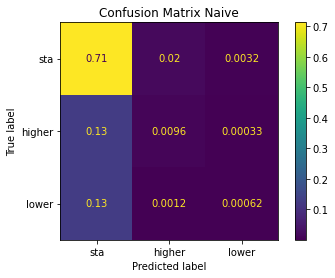

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cmNaiv = confusion_matrix(encTe.argmax(axis=1), encPr.argmax(axis=1),normalize='all')
dispNaiv = ConfusionMatrixDisplay(confusion_matrix=cmNaiv,display_labels=['sta','higher','lower'])
dispNaiv.plot()
dispNaiv.ax_.set_title("Confusion Matrix Naive");

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,10))
ax[0].set_title("CNN/LSTM")
ax[1].set_title("LSTM")
ax[2].set_title("Naive")

cm = confusion_matrix(testY.argmax(axis=1), pj.argmax(axis=1),normalize='pred')#true', 'pred', 'all'
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['sta','higher','lower'])
disp.plot(ax=ax[0])
disp.ax_.set_title("Confusion Matrix CNN/LSTM")
cm_lstm = confusion_matrix(testY_lstm.argmax(axis=1), P_lstm.argmax(axis=1),normalize='pred')#true', 'pred', 'all'
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm,display_labels=['sta','higher','lower'])
disp_lstm.plot(ax=ax[1])
disp_lstm.ax_.set_title("Confusion Matrix LSTM")
cmNaiv = confusion_matrix(encTe.argmax(axis=1), encPr.argmax(axis=1),normalize='pred')
dispNaiv = ConfusionMatrixDisplay(confusion_matrix=cmNaiv,display_labels=['sta','higher','lower'])
dispNaiv.plot(ax=ax[2])
dispNaiv.ax_.set_title("Confusion Matrix Naive");

In [ ]:
stop

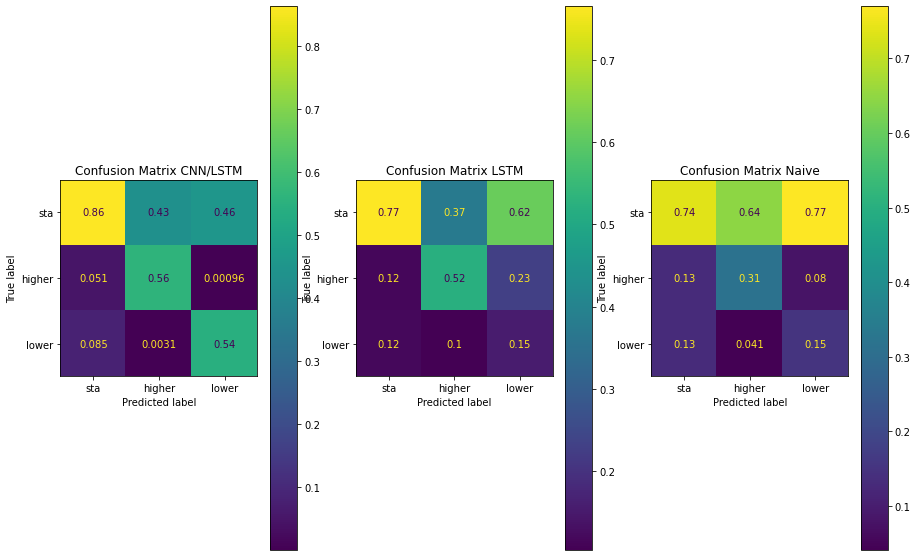

In [34]:
fig, ax = plt.subplots(1,3, figsize=(15,10))
ax[0].set_title("CNN/LSTM")
ax[1].set_title("LSTM")
ax[2].set_title("Naive")

cm = confusion_matrix(testY.argmax(axis=1), pj.argmax(axis=1),normalize='pred')#true', 'pred', 'all'
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['sta','higher','lower'])
disp.plot(ax=ax[0])
disp.ax_.set_title("Confusion Matrix CNN/LSTM")
cm_lstm = confusion_matrix(testY_lstm.argmax(axis=1), P_lstm.argmax(axis=1),normalize='pred')#true', 'pred', 'all'
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm,display_labels=['sta','higher','lower'])
disp_lstm.plot(ax=ax[1])
disp_lstm.ax_.set_title("Confusion Matrix LSTM")
cmNaiv = confusion_matrix(encTe.argmax(axis=1), encPr.argmax(axis=1),normalize='pred')
dispNaiv = ConfusionMatrixDisplay(confusion_matrix=cmNaiv,display_labels=['sta','higher','lower'])
dispNaiv.plot(ax=ax[2])
dispNaiv.ax_.set_title("Confusion Matrix Naive");

In [ ]:
STOP

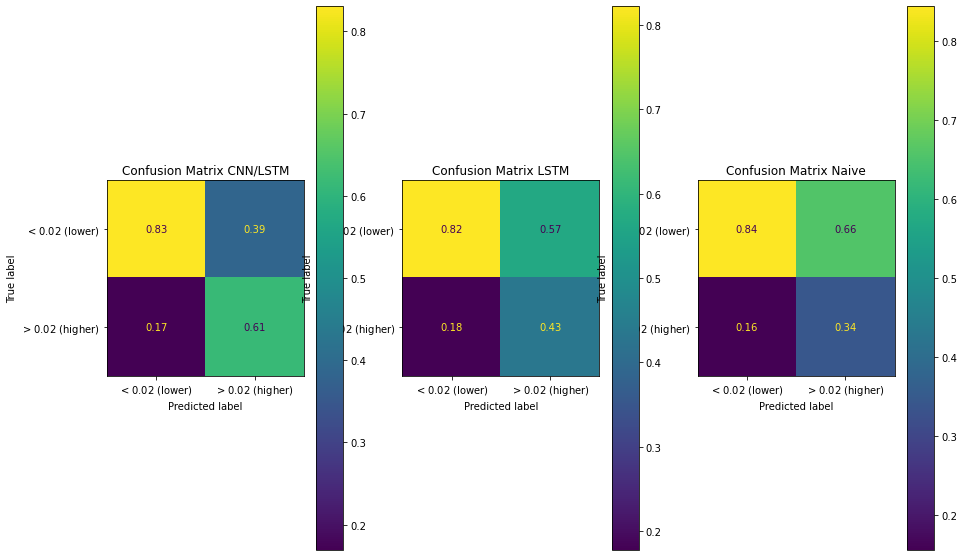

In [34]:
fig, ax = plt.subplots(1,3, figsize=(15,10))
ax[0].set_title("CNN/LSTM")
ax[1].set_title("LSTM")
ax[2].set_title("Naive")

cm = confusion_matrix(testY.argmax(axis=1), pj.argmax(axis=1),normalize='pred')#true', 'pred', 'all'
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['$<0.02$ (lower)','$>0.02$ (higher)'])
disp.plot(ax=ax[0])
disp.ax_.set_title("Confusion Matrix CNN/LSTM")
cm_lstm = confusion_matrix(testY_lstm.argmax(axis=1), p_lstmj.argmax(axis=1),normalize='pred')#true', 'pred', 'all'
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm,display_labels=['$<0.02$ (lower)','$>0.02$ (higher)'])
disp_lstm.plot(ax=ax[1])
disp_lstm.ax_.set_title("Confusion Matrix LSTM")
cmNaiv = confusion_matrix(encTe.argmax(axis=1), encPr.argmax(axis=1),normalize='pred')
dispNaiv = ConfusionMatrixDisplay(confusion_matrix=cmNaiv,display_labels=['$<0.02$ (lower)','$>0.02$ (higher)'])
dispNaiv.plot(ax=ax[2])
dispNaiv.ax_.set_title("Confusion Matrix Naive");

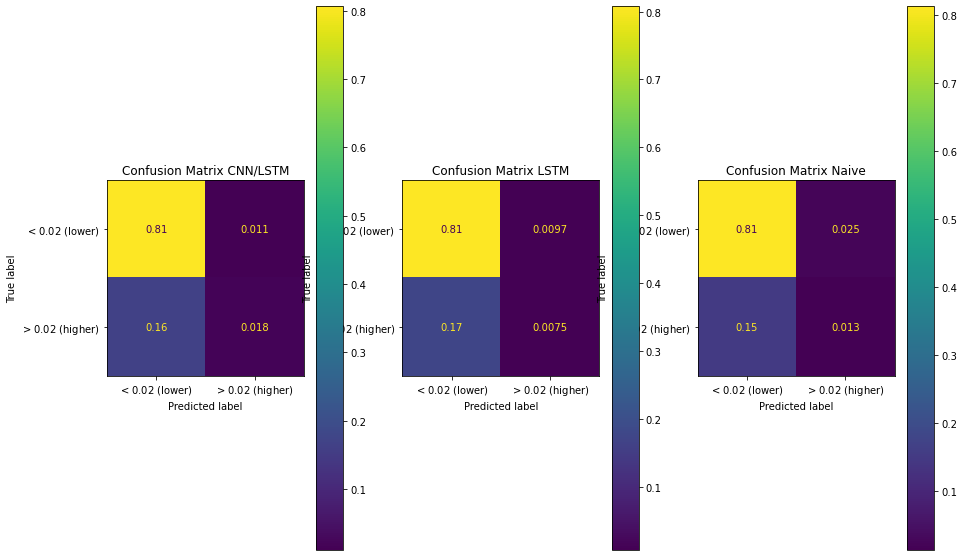

In [33]:
fig, ax = plt.subplots(1,3, figsize=(15,10))
ax[0].set_title("CNN/LSTM")
ax[1].set_title("LSTM")
ax[2].set_title("Naive")

cm = confusion_matrix(testY.argmax(axis=1), pj.argmax(axis=1),normalize='all')#true', 'pred', 'all'
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['$<0.02$ (lower)','$>0.02$ (higher)'])
disp.plot(ax=ax[0])
disp.ax_.set_title("Confusion Matrix CNN/LSTM")
cm_lstm = confusion_matrix(testY_lstm.argmax(axis=1), p_lstmj.argmax(axis=1),normalize='all')#true', 'pred', 'all'
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm,display_labels=['$<0.02$ (lower)','$>0.02$ (higher)'])
disp_lstm.plot(ax=ax[1])
disp_lstm.ax_.set_title("Confusion Matrix LSTM")
cmNaiv = confusion_matrix(encTe.argmax(axis=1), encPr.argmax(axis=1),normalize='all')
dispNaiv = ConfusionMatrixDisplay(confusion_matrix=cmNaiv,display_labels=['$<0.02$ (lower)','$>0.02$ (higher)'])
dispNaiv.plot(ax=ax[2])
dispNaiv.ax_.set_title("Confusion Matrix Naive");
#plt.tight_layout()  ;

0.9980000000000001

1) Precision is a measure of how many of the positive predictions made are correct (true positives).
2) Accuracy describes the number of correct predictions over all predictions (TP+TN)/sizePop.
3) Recall is a measure of how many of the positive cases the classifier correctly predicted, over all the positive cases in the data.
4) F1 provides a single metric that weights the two ratios (precision and recall) in a balanced way.
    - Very small precision or recall will result in lower overall score. Thus it helps balance the two metrics.
    - If you choose your positive class as the one with fewer samples, F1-score can help balance the metric across positive/negative samples.